In [1]:
import sys
print(sys.version)
print(spark.version)

3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]
3.1.3


In [2]:
import os
import time
import subprocess
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

In [3]:
warnings.filterwarnings(action='ignore')
spark = SparkSession.builder.getOrCreate()

##Add "eagerEval.enabled" to beautify the way Spark DF is displayed
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

## To use legacy casting notation for date
spark.conf.set("spark.sql.legacy.timeParserPolicy","LEGACY")

In [4]:
filtered=spark.read.parquet('gs://msca-bdp-students-bucket/shared_data/sirivanth/new_filtered')

23/03/08 01:30:10 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
filtered = filtered.sample(0.5)

In [6]:
filtered.createOrReplaceTempView("filtered")

In [7]:
query = '''
select retweeted as Retweeted,
retweeted_status.id as r_status_id,
retweeted_status.user.screen_name as r_status_user,
user.screen_name as Profile,
user.description as Description,
user.verified as user_verified,
user.followers_count as followers,
user.statuses_count as tweets_count
from filtered'''
a = spark.sql(query)

In [8]:
b = a.filter(col('user_verified') == True).withColumn("Organisation",when(col("Description").rlike('.*republic.*|.*congress.*|.*parliament.*|.*senat.*|.*president.*|.*democr.*|.*prime minister.*|.*Government.*|.*MLA.*|.*mla.*|.*gov.*|.*u.s..*|.*U.S..*|.*US.*|.*united states.*|.*government.*'),"Government")
                .when(col("Description").rlike('.*University.*|.*university.*|.*school.*|.*School.*|.*research.*|.*teaching.*|.*college.*|.*edu.*|.*graduate.*|.*undergraduate.*|.*bachelorsdegree.*|.*Bachelorsdegree.*|.*degree.*|.*Degree.*'),"Education")
                .when(col("Description").rlike('.*News.*|.*news.*|.*Media.*|.*media.*|.*journal.*|.*podcasts.*|.*podcast.*'),"News")
                .when(col("Description").rlike('.*nonprofit.*|.*Nonprofit.*|.*NGO.*|.*ngo.*|.*volunteers.*|.*Volunteers.*|.*Fundraising.*|.*fundraising.*|.*Charity.*|.*charity.*'),"NGO")
                .when(col("Description").rlike('.*influencer.*|.*Influencer.*|.*author.*|.*actress.*|.*musician.*|.*singer.*|.*crickter.*|.*Actor.*|.*actor.*|.*Actress.*|.*Cricter.*'),"Influencer"))                                                    

In [9]:
b.createOrReplaceTempView("filtered")

In [10]:
spark.sql("select Profile,Organisation,Description from filtered where Organisation = 'Education'").toPandas().head(10)

,Profile,Organisation,Description
0,BarmakN,Education,#education #privacy #politics. Personal accoun...
1,MJournalSports,Education,The @MorningJournal sports staff gives readers...
2,PolkSchoolsNews,Education,"Hello, we are Polk County Public Schools -- on..."
3,RepWilson,Education,Lifelong educator serving Florida’s 24th Distr...
4,dynarski,Education,economist | inequality & education | 1st-gen |...
5,ethan_harsell,Education,“Hershey” | ΔΤΔ | NoDak | legislative candidat...
6,hannahjonestv,Education,University of Alabama alum - born & bred in Sa...
7,corbymeekins,Education,Assistant Head Coach / TE / Inside WR Coach | ...
8,Miamicurt,Education,Associated Press reporter in Tampa Bay. Proud ...
9,CityCollegeNY,Education,"Celebrating 175: Since 1847, 1st public instit..."


In [11]:
#filtered.createOrReplaceTempView("filtered")

In [12]:
Organization = spark.sql("select Organisation,count(*) count from filtered group by Organisation").toPandas()

In [13]:
Organization.head()

,Organisation,count
0,Education,29438
1,None,101744
2,Government,34421
3,NGO,844
4,Influencer,3621


<AxesSubplot:xlabel='Organisation', ylabel='Tweet Count'>

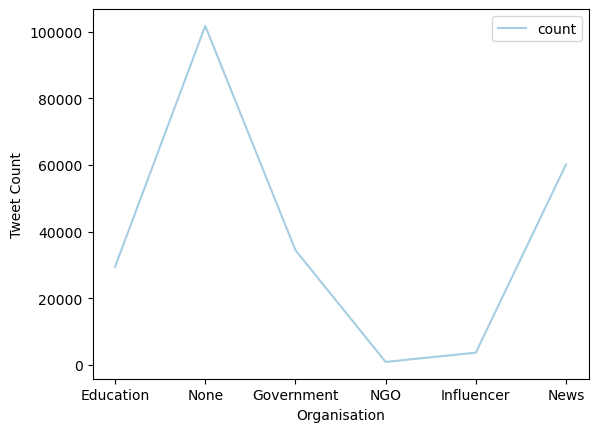

In [14]:
Organization.plot.line(x='Organisation',y='count',colormap='Paired',xlabel='Organisation',ylabel='Tweet Count')

<AxesSubplot:xlabel='Organisation', ylabel='Tweet Count'>

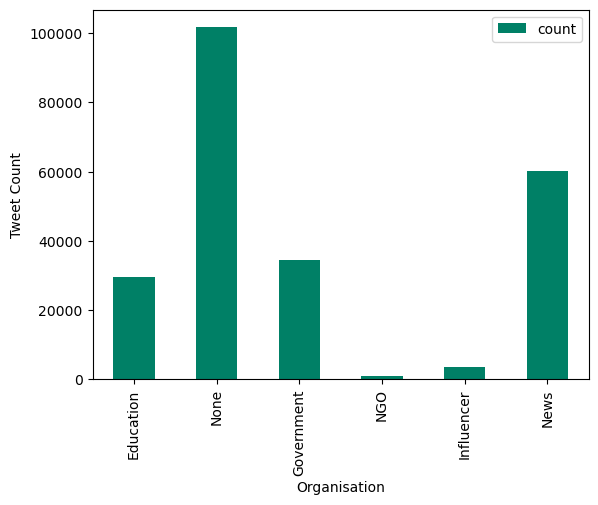

In [15]:
Organization.plot.bar(x='Organisation',y='count',colormap='summer',xlabel='Organisation',ylabel='Tweet Count')

In [16]:
filtered.createOrReplaceTempView("filtered")

In [17]:
query = '''
select retweeted as Retweeted,
retweeted_status.id as r_status_id,
retweeted_status.user.screen_name as r_status_user,
retweeted_status.user.description as rt_desc,
user.screen_name as Profile,
user.description as Description,
user.verified as user_verified,
user.followers_count as followers,
user.statuses_count as tweets_count
from filtered'''
a = spark.sql(query)

In [18]:
b = a.withColumn("Organisation",when(col("Description").rlike('.*republic.*|.*congress.*|.*parliament.*|.*senat.*|.*president.*|.*democr.*|.*prime minister.*|.*Government.*|.*MLA.*|.*mla.*|.*gov.*|.*u.s..*|.*U.S..*|.*US.*|.*united states.*|.*government.*'),"Government")
                .when(col("Description").rlike('.*University.*|.*university.*|.*school.*|.*School.*|.*research.*|.*teaching.*|.*college.*|.*edu.*|.*graduate.*|.*undergraduate.*|.*bachelorsdegree.*|.*Bachelorsdegree.*|.*degree.*|.*Degree.*'),"Education")
                .when(col("Description").rlike('.*News.*|.*news.*|.*Media.*|.*media.*|.*journal.*|.*podcasts.*|.*podcast.*'),"News")
                .when(col("Description").rlike('.*nonprofit.*|.*Nonprofit.*|.*NGO.*|.*ngo.*|.*volunteers.*|.*Volunteers.*|.*Fundraising.*|.*fundraising.*|.*Charity.*|.*charity.*'),"NGO")
                .when(col("Description").rlike('.*influencer.*|.*Influencer.*|.*author.*|.*actress.*|.*musician.*|.*singer.*|.*crickter.*|.*Actor.*|.*actor.*|.*Actress.*|.*Cricter.*'),"Celebrity"))                                                           

In [19]:
b.createOrReplaceTempView("b")

In [20]:
u = b.withColumn("R_Organisation",when(col("Description").rlike('.*republic.*|.*congress.*|.*parliament.*|.*senat.*|.*president.*|.*democr.*|.*prime minister.*|.*Government.*|.*MLA.*|.*mla.*|.*gov.*|.*u.s..*|.*U.S..*|.*US.*|.*united states.*|.*government.*'),"Government")
                .when(col("Description").rlike('.*University.*|.*university.*|.*school.*|.*School.*|.*research.*|.*teaching.*|.*college.*|.*edu.*|.*graduate.*|.*undergraduate.*|.*bachelorsdegree.*|.*Bachelorsdegree.*|.*degree.*|.*Degree.*'),"Education")
                .when(col("Description").rlike('.*News.*|.*news.*|.*Media.*|.*media.*|.*journal.*|.*podcasts.*|.*podcast.*'),"News")
                .when(col("Description").rlike('.*nonprofit.*|.*Nonprofit.*|.*NGO.*|.*ngo.*|.*volunteers.*|.*Volunteers.*|.*Fundraising.*|.*fundraising.*|.*Charity.*|.*charity.*'),"NGO")
                .when(col("Description").rlike('.*influencer.*|.*Influencer.*|.*author.*|.*actress.*|.*musician.*|.*singer.*|.*crickter.*|.*Actor.*|.*actor.*|.*Actress.*|.*Cricter.*'),"Celebrity"))                                                             

In [21]:
u.createOrReplaceTempView("u")

In [ ]:
df_tweet = spark.sql('select Organisation, count(*) from b group by Organisation').toPandas()

In [ ]:
df_retweet = spark.sql('select R_Organisation, count(*) from u where r_status_user is not null group by R_Organisation order by count(*) desc').toPandas()

In [ ]:
df_retweet.fillna('Rest',inplace=True)

In [ ]:
df_tweet.fillna('Rest',inplace=True)

In [ ]:
df_tweet = df_tweet[df_tweet['Organisation'] != 'Rest']

In [ ]:
df_retweet = df_retweet[df_retweet['R_Organisation'] != 'None']

In [ ]:
df_tweet = df_tweet.sort_values(by='Organisation')

In [ ]:
df_retweet = df_retweet.sort_values(by='R_Organisation')

In [ ]:
df_retweet.drop(df_retweet[df_retweet["R_Organisation"] == "Rest"].index, inplace=True)

In [ ]:
df_retweet

,R_Organisation,count(1)
4,Celebrity,88019
2,Education,585087
1,Government,953244
5,NGO,29124
3,News,255161


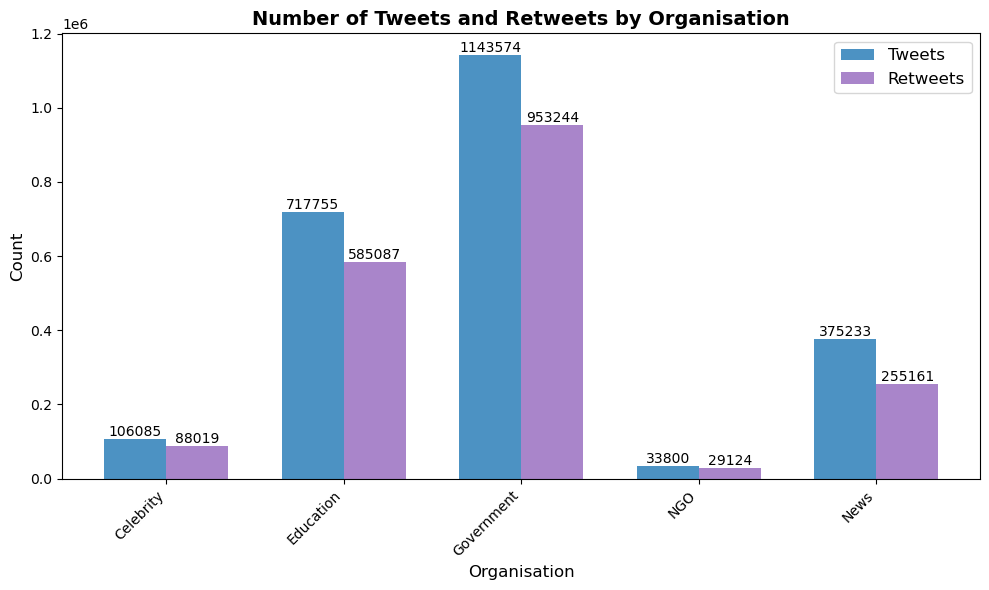

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# create subplots and set figure size
fig, ax = plt.subplots(figsize=(10,6))

# set index for each organization
index = np.arange(len(df_tweet['Organisation']))
index2 = np.arange(len(df_retweet['R_Organisation']))

# set bar width and opacity
bar_width = 0.35
opacity = 0.8

# plot bars for tweets and retweets
ax.bar(index, df_tweet['count(1)'], color='#1f77b4', align='edge', width=bar_width, alpha=opacity, label='Tweets')
ax.bar(index+bar_width, df_retweet['count(1)'], color='#9467bd', align='edge', width=bar_width, alpha=opacity, label='Retweets')

# display count above each bar
for i, count in enumerate(df_tweet['count(1)']):
    ax.text(i + bar_width/2, count+1, str(count), ha='center', va='bottom')
for i, count in enumerate(df_retweet['count(1)']):
    ax.text(i + bar_width*1.5, count+1, str(count), ha='center', va='bottom')

# set tick labels and rotation
ax.set_xticks(index + bar_width)
ax.set_xticklabels(df_tweet['Organisation'], rotation=45, ha='right')

# set axis labels and legend
ax.set_xlabel('Organisation', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.legend(fontsize=12)

# set plot title and tighten layout
plt.title('Number of Tweets and Retweets by Organisation', fontsize=14, fontweight='bold')
fig.tight_layout()

# show the plot
plt.show()
